# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

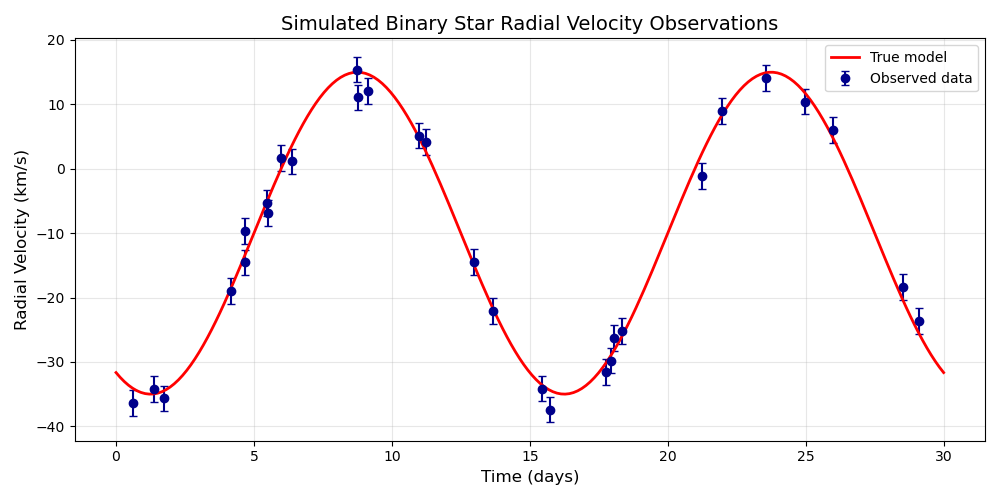

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [2]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [12]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    K = theta[0]
    P = theta[1]
    t0 = theta[2]
    v0 = theta[3]

    v_model = radial_velocity_model(t, K, P, t0, v0)

    chi2 = np.sum((v - v_model)**2 / v_err**2)
    loglike = -0.5 * chi2

    return loglike


def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    K = theta[0]
    P = theta[1]
    t0 = theta[2]
    v0 = theta[3]

    if not (22 < K < 28):
        return -np.inf
    if not (13 < P < 17):
        return -np.inf
    if not (3< t0 < 7):
        return -np.inf
    if not (-12 < v0 < -8):
        return -np.inf

    return 0


def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    prior = log_prior(theta)

    if not np.isfinite(prior):
        return -np.inf

    loglike = log_likelihood(theta, t, v, v_err)

    return prior + loglike

    # you're doing this

#### Justify the choice of prior in a few sentences

I make sure each of [K, P, t0, v0] is within a small range. I went off of v_err = 2 to give the v0 range a margin of 2, and I based the other margins on this value. K's margin is slightly larger to account for K being the largest absolute value.


#### Describe how you treated the uncertainties in a few sentences

I use the uncertainties in the log likelihood function to calculate chi-squared. The log likelihood function is what's being optimized, so the chi-squared should be minimized.


#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [17]:
# MCMC setup
ndim = 6
nwalkers = 20
nsteps = 10000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

import emcee
import corner

starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(v_err, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, 4))


#### Run the MCMC Sampler
This may take a minute or two.

In [29]:
# Initialize the sampler
K = np.random.choice(np.linspace(22, 28, nsteps))
P = np.random.choice(np.linspace(13, 17, nsteps))
t0 = np.random.choice(np.linspace(3, 7, nsteps))
v0 = np.random.choice(np.linspace(-12, -8, nsteps))
theta = [K, P, t0, v0]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = [theta, 4, v_err])

# Run MCMC
running =  sampler.run_mcmc(starting_guesses, nsteps, rstate0 = np.random.get_state())


# Print the acceptance fraction from the sampler



/Users/erika/anaconda3/envs/astr496/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


In [30]:
np.mean(sampler.acceptance_fraction)

np.float64(0.0)

#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

In [91]:
running[0][:, 0]

array([2.47323762, 1.15320628, 1.55348505, 2.21409374, 2.17318093,
       1.11614256, 2.05820872, 2.35778736, 3.08305124, 0.62233063,
       2.51503527, 2.51504769, 2.57089051, 2.95400176, 1.68473076,
       1.22717479, 1.51463645, 4.31465857, 2.68626019, 1.52806813])

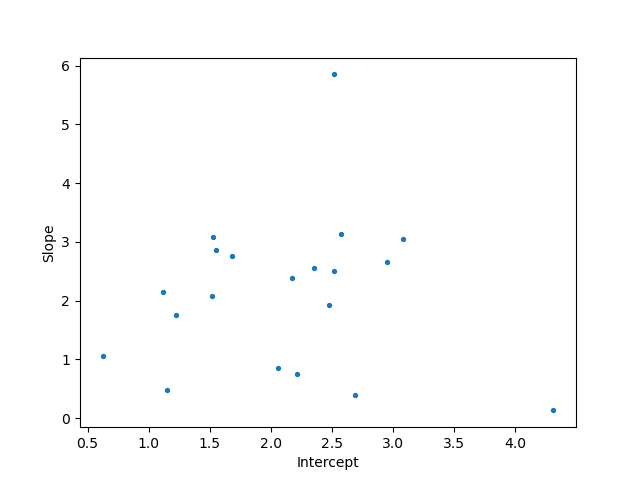

In [79]:
plt.figure()
plt.scatter(running[0][:, 0], running[0][:, 1], s = 8) ## slopes and intercepts
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.show()

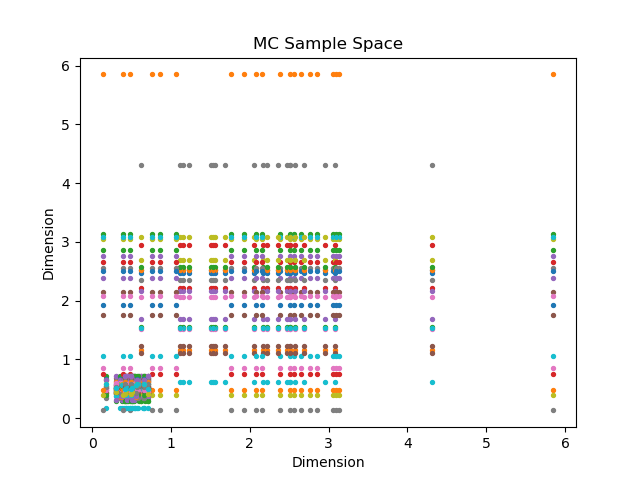

In [ ]:
# Plot the chains - and remember to label your plots - you aren't silly first-years

plt.figure()
for i in range(len(running[0])):  
    for j in range(len(running[0])): 
        plt.scatter(running[0][i], running[0][j], s = 8)
plt.title("MC Sample Space")
plt.xlabel("Dimension")
plt.ylabel("Dimension")
plt.show()

In [80]:
# Calculate autocorrelation time



#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [ ]:
# Get flattened samples (discard burn-in and thin)
nburn = 5000
burn = sampler.chain[:, nburn:, :].reshape(-1, ndim)

n_thin = 100
thinned = []
count = 0
for i in range(len(running[0])):
    for j in range(len(running[0][0])):
        count = count + 1
        temp = running[0][i][j]
        if count % 100 == 0:
            thinned.append(temp)

thinned
# Calculate parameter estimates


[np.float64(0.4506999065341167)]

#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

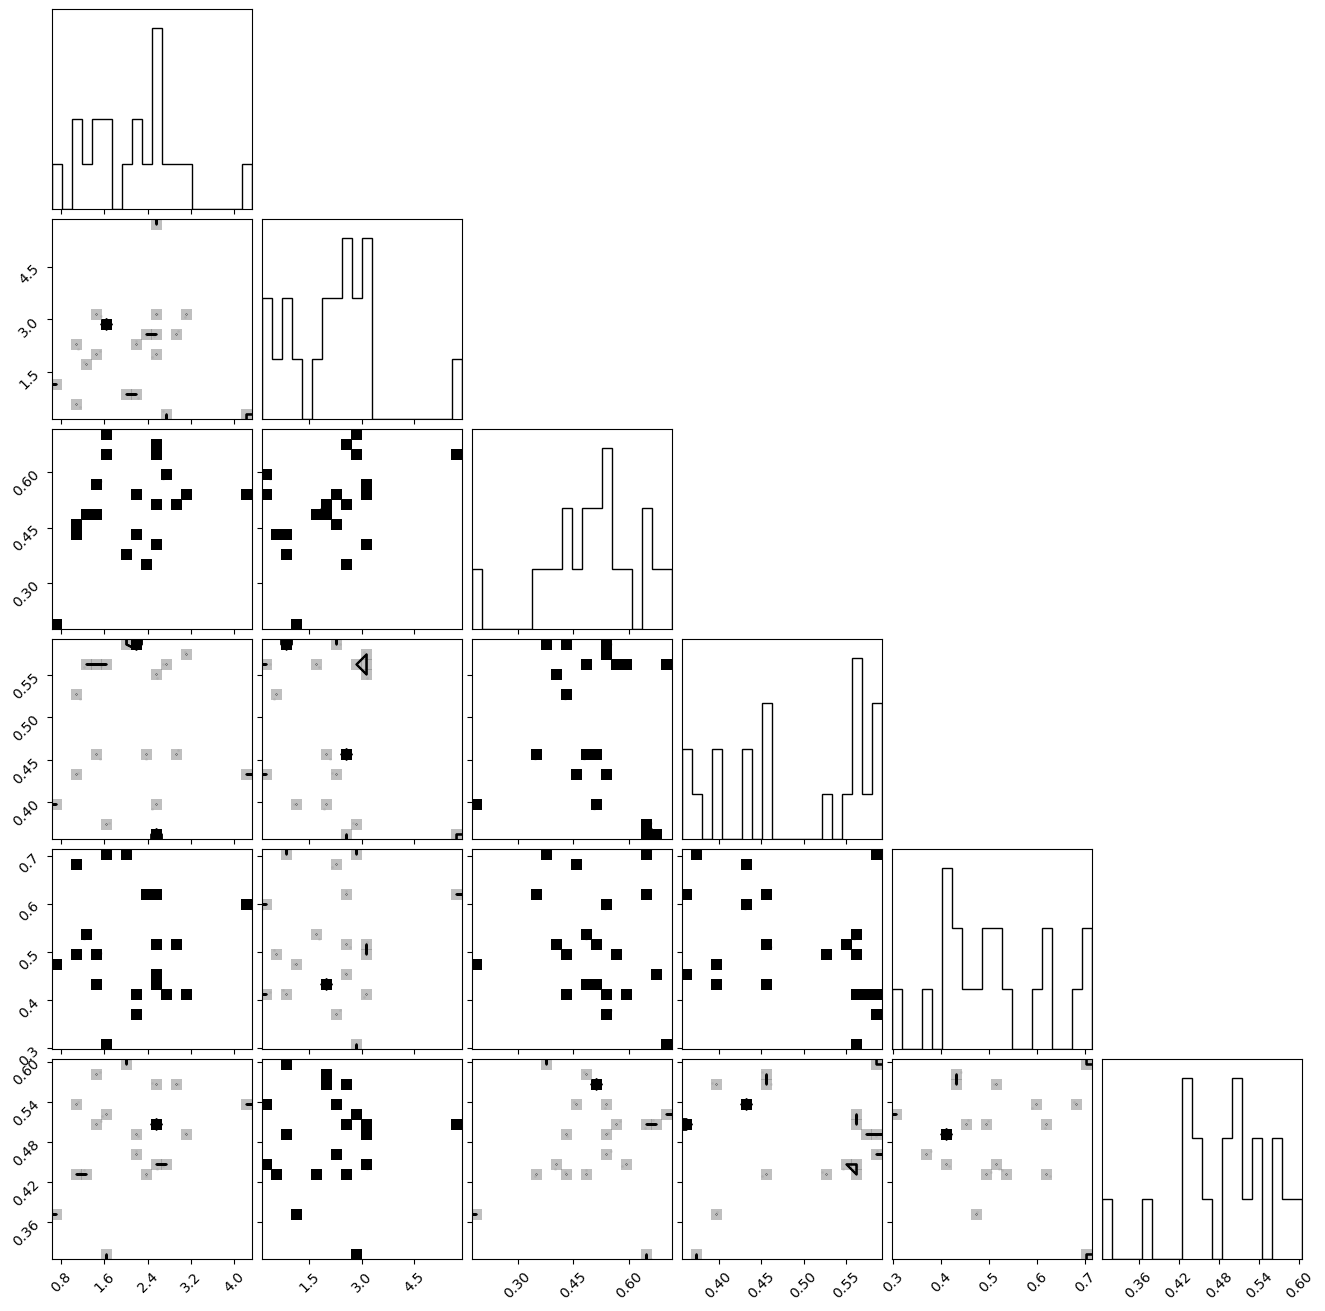

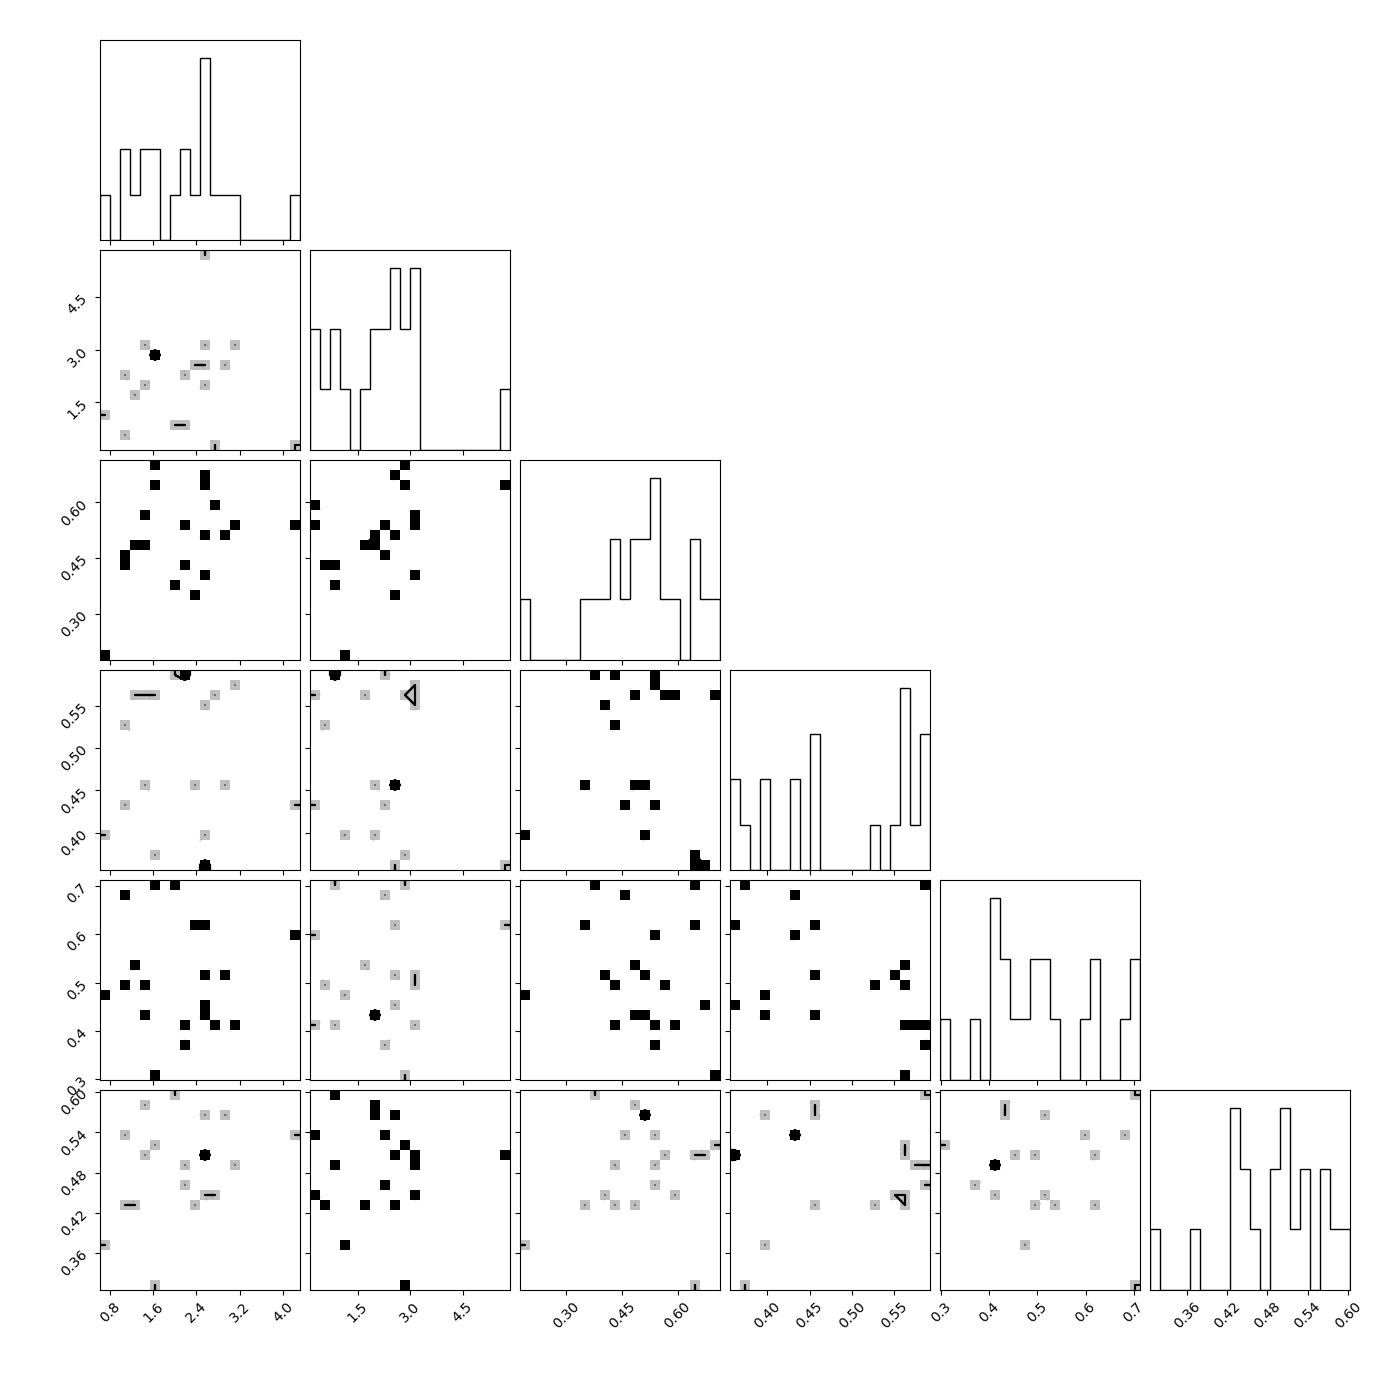

In [84]:
# you can use the corner package 

corner.corner(running[0])

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

In [94]:
running

State([[2.47323762 1.92717109 0.506428   0.39222552 0.42846963 0.56795977]
 [1.15320628 0.48515278 0.42696334 0.52164586 0.50455718 0.43483997]
 [1.55348505 2.85639879 0.71439441 0.5633919  0.29748574 0.51864543]
 [2.21409374 0.75426122 0.43382135 0.58524333 0.42074793 0.48852636]
 [2.17318093 2.38531738 0.55049873 0.58657552 0.37997036 0.46654988]
 [1.11614256 2.15372511 0.45250547 0.43466708 0.67654542 0.54049817]
 [2.05820872 0.8570297  0.3739116  0.59178619 0.71221562 0.60324653]
 [2.35778736 2.56078453 0.348063   0.45157659 0.62669111 0.42923305]
 [3.08305124 3.05380205 0.54438194 0.57746341 0.40730695 0.49404746]
 [0.62233063 1.06217496 0.17587327 0.39756124 0.47474318 0.37522168]
 [2.51503527 2.51378595 0.66324113 0.35698586 0.45599555 0.51307406]
 [2.51504769 5.85273149 0.64412733 0.35641378 0.61631638 0.50102331]
 [2.57089051 3.13556564 0.40184913 0.54621035 0.51990597 0.43997831]
 [2.95400176 2.65139125 0.50698021 0.46146864 0.51135173 0.56621307]
 [1.68473076 2.75896922 0.65

<function matplotlib.pyplot.show(block=None)>

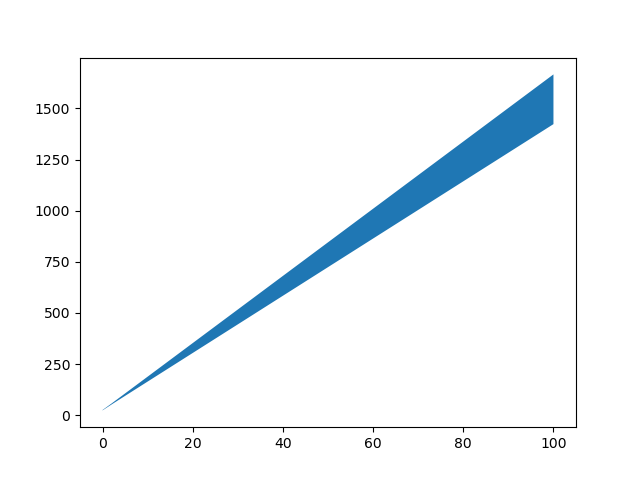

In [ ]:
# also plot the true model - you can look at the simulation code

inds = np.random.choice(np.arange(0, len(running[0][:, 0])), 30)
intercepts = running[0][:,0][inds]
slopes = running[0][:,1][inds]

xfit = np.linspace(0, 100)
y_vals = np.add( np.outer(slopes, xfit), intercepts[:,np.newaxis])
y_stds = np.std(y_vals, axis=0)

plt.figure()
plt.fill_between(xfit, theta[0] + theta[1] * xfit - y_stds, theta[0] + theta[1] * xfit + y_stds)
plt.show

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

None of my parameters are strongly correlated.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

ANSWER GOES HERE

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?


Too few walkers would increase the time necessary to estimate the distribution, and too few steps would create an incomplete representation of the distribution.
